# Finger People experimental playground

In [1]:
import numpy as np
import cv2
import os
import math
import urllib
import time

import matplotlib.pyplot as plt

from helpers import imshow


## Input Sources
### Helpers

In [2]:
def get_cap(source, source_type='video'):
    
    if type(source) == int:
        cap = cv2.VideoCapture(source)
        w = 180
        h = w * 3/4
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h) 
        #cap.set(cv2.CAP_PROP_FPS, 60)
        
    elif source_type == 'video':
        cap = cv2.VideoCapture(source)
        cap.set(cv2.CAP_PROP_FPS, 30)
        
    else:
        cap = WebCapture(source)
        
    return cap

def kill_cap(cap):
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)


### Video File

In [6]:
cap_source = 'samples/all_moves_1_180.mp4'
cap_type = 'video'

# all_moves_1 sizes: 360, 180, 90, 46

### Camera

In [10]:
cap_source = 0
cap_type = 'camera'

### Android (via web)

In [3]:
cap_source = 'http://192.168.1.4:8080/shot.jpg'
cap_type = 'web'

class WebCapture:
    
    def __init__(self, url):
        self.url = url
        
    def read(self):
        try:
            img_resp = urllib.request.urlopen(self.url)
            img_np = np.array(bytearray(img_resp.read()), dtype=np.uint8)
            img = cv2.imdecode(img_np, -1)
            return True, img
        except:
            return False, None
        
    def isOpened(self):
        return True
    
    def release(self):
        pass
        

## Skin Detection Clibration

In [19]:
def hsv_mask(img, lower, upper):
    '''
    Given a BGR image, returns a mask of pixels within lower and upper HSV space
    
    mask = hsv_mask(img, lower, upper)
    
    input
        img: A BGR image
        lower: 3-tuple with hue, saturation, and value of lower cutoff of mask
        upper: 3-tuple with hue, saturation, and value of upper cutoff of mask
        
    output
        mask: binary mask of pixels with HSV values between lower and upper
    '''
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = np.zeros((img.shape[:2]), dtype=np.uint8)
    
    if lower[0] > upper[0]:
        # To account for hue wrapping around 180 to 0
        lower_middle = (180, upper[1], upper[2])
        upper_middle = (0,   lower[1], lower[2])
        
        mask_lower = cv2.inRange(hsv, lower, lower_middle)
        mask_upper = cv2.inRange(hsv, upper_middle, upper)
        
        mask = mask_lower + mask_upper
        
    else:
        mask = cv2.inRange(hsv, lower, upper)
    
    return mask

def get_roi_sample(cap, size=1/8):
    '''
    Draws a rectangle on the screen
    Returns the pixels in the region upon pressing space
    
    size is a fraction of the screen height
    '''
    _ret, frame = cap.read()
    h = frame.shape[0]
    w = frame.shape[1]
    
    size /= 2
    p0 = (int(w/2-h*size), int(h/2-h*size))
    p1 = (int(w/2+h*size), int(h/2+h*size))
    
    while cap.isOpened():
        _ret, frame = cap.read()
        frame = cv2.flip(frame, 1)  
        
        #frame = cv2.GaussianBlur(frame, (13,13), 0)
        
        if not _ret:
            break
            
        frame_display = frame.copy()
        cv2.rectangle(frame_display, p0, p1, (0,255,0), 2)
        cv2.imshow('frame', frame_display)
        
        key = cv2.waitKey(5)
        if key == ord(' '):
            break
            
    box_sample = frame[p0[1]:p1[1], p0[0]:p1[0]]
    return box_sample

def get_hsv_range(imgs):
    '''
    min_hsv, max_hsv = get_hsv_range(imgs)
    
    Finds and returns the bounds of a set of hsv images.
    Shifts hue such that blue is around the 180/0 border 
    so that skin range can be easily evaluated
    
    Input
        imgs: bgr images
    
    Output
        min_hsv: 3-tuple containing the mininum hue, saturation, and value found in img
        max_hsv: 3-tuple containing the maximum hue, saturation, and value found in img
    '''
    min_hsvs = []
    max_hsvs = []
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hue = img[:,:,0]
        sat = img[:,:,1]
        val = img[:,:,2]

        hue = (hue + 90)%180 # shift skin hues away from the 180/0 border
        min_hue, max_hue, _, _ = cv2.minMaxLoc(hue)
        min_sat, max_sat, _, _ = cv2.minMaxLoc(sat)
        min_val, max_val, _, _ = cv2.minMaxLoc(val)
        
        min_hsvs.append((min_hue, min_sat, min_val))
        max_hsvs.append((max_hue, max_sat, max_val))
        
    # NOTE: these functions could be changed
    #... using minimax for now
    min_hsv = np.amin(np.array(min_hsvs), axis=0)
    max_hsv = np.amax(np.array(max_hsvs), axis=0)
    
    min_hsv[0] = (min_hsv[0] + 90)%180
    max_hsv[0] = (max_hsv[0] + 90)%180

    return min_hsv, max_hsv

def mean_hist(samples, channels=[0,1], ranges=[0,180,0,256], bins=[32,32]):
    '''
    Gets a mean histogram of all the sample images.
    
    Inputs:
        samples is a list of sample images
        channels defines the channels to use
        ranges specifies the range of each channel
        num_bins is the number of bins for each channel
        
    Outputs:
        hist is the mean histogram
    '''
    hists = np.array([cv2.calcHist([sample], channels, None, bins, ranges) for sample in samples])
    hist = np.mean(hists, axis=0)
    return hist

def hist_mask(img, hist, thresh=1, channels=[0,1], ranges=[0,180,0,256]):
    backProj = cv2.calcBackProject([img], channels, hist, ranges, 1)
    if thresh is not None:
        ret, mask = cv2.threshold(backProj, 1, 255, cv2.THRESH_BINARY)
    else:
        mask = backProj
    return mask


# HSV ranges for skin detection (with perferct conditions)
#skin_hsv_lower = np.array([0,  24,  80 ], dtype = "uint8")
#skin_hsv_upper = np.array([20, 120, 255], dtype = "uint8")
#skin_hsv_lower, skin_hsv_upper = get_hsv_range(skin_samples)  
#print('Skin range {} {}'.format(skin_hsv_lower, skin_hsv_upper))

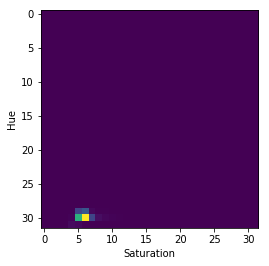

In [23]:
HUE = 0
SAT = 1
channels = [HUE, SAT]

HUE_RANGE = (0,180)
SAT_RANGE = (0,256)
ranges = [*HUE_RANGE, *SAT_RANGE]

num_bins = 32
bins = [num_bins]*len(channels)

sat_thresh = 16 # any saturations below will be thrown out due to instability
sat_thresh_bin = int(sat_thresh/SAT_RANGE[1]*num_bins)

# Get samples of skin
cap = get_cap(cap_source, cap_type)
skin_samples = []
for _ in range(5):
    skin_samples.append(cv2.cvtColor(get_roi_sample(cap), cv2.COLOR_BGR2HSV))
kill_cap(cap)

# Calculate histogram
skin_hist = mean_hist(skin_samples, channels=channels, ranges=ranges, bins=bins)
skin_hist[:, :sat_thresh_bin] = 0
plt.xlabel('Saturation')
plt.ylabel('Hue')
plt.imshow(skin_hist)

# Create function to mask skin
mask_skin = lambda frame, thresh=1: hist_mask(frame, skin_hist, thresh=thresh, channels=channels, ranges=ranges)

## Finger People

In [ ]:
cap = get_cap(cap_source, cap_type)

MIN_BLOB_SIZE = 50
mhi_alpha = 0.5

JUMP_THRESH = 1.0
JUMP_RATIO  = 1.0 # x must be ratio more than y

# Parameters for farneback optical flow
fb_params = dict( pyr_scale = 0.5, 
                  levels = 3, 
                  winsize = 5, 
                  iterations = 3, 
                  poly_n = 5,
                  poly_sigma = 1.2, 
                  flags = 0 )

# Take the first frame
_ret, init_frame = cap.read()
prvs = cv2.cvtColor(init_frame,cv2.COLOR_BGR2GRAY)
frame1 = cv2.flip(init_frame, 1)

h = init_frame.shape[0]
w = init_frame.shape[1]

# For color representation of optical flow
flow_vis = np.zeros_like(init_frame)
flow_vis[...,1] = 255

# Motion history image
mag_hist = np.zeros((init_frame.shape[:2]), dtype=np.float32)
ang_hist = np.zeros((init_frame.shape[:2]), dtype=np.float32)
mhi = np.zeros_like(init_frame)
mhi[...,1] = 255

while cap.isOpened():
    
    # Get the next frame
    _ret, frame = cap.read()
    frame = cv2.flip(frame, 1)  
    if not _ret:
        break
      
    
    
    ''' SKIN MASK '''
    #blurred = cv2.GaussianBlur(frame, (13,13), 0)
    skin_mask = mask_skin(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV), thresh=1)
    hand_mask = skin_mask
    #skin_mask = hsv_mask(cv2.GaussianBlur(frame, (13,13), 0), skin_hsv_lower, skin_hsv_upper)
    
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
#     skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel, iterations = 2)
#     skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations = 2)
    
#     # Find the lowest contour above the min size -- this should be a hand
#     im, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     lowest_contour = None
#     lowest_contour_height = math.inf
    
#     for i, contour in enumerate(contours):
        
#         if cv2.contourArea(contour) <= MIN_BLOB_SIZE:
#             continue
            
#         m = cv2.moments(contour)
#         contour_height = m['m10']/m['m00']

#         if contour_height < lowest_contour_height:
#             lowest_contour = i
#             lowest_contour_height = contour_height
            
#     # Draw in hand blob
#     hand_mask = np.zeros_like(skin_mask)
#     if lowest_contour:
#         cv2.drawContours(hand_mask, contours, lowest_contour, 255, -1)

        
        
    ''' OPTICAL FLOW '''
    next = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, **fb_params)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    # Ignore non-hand movement
    #mag = cv2.bitwise_and(mag, mag, mask=hand_mask)    
       
        
        
    ''' MHI '''
    mag_hist = mhi_alpha*mag_hist + (1-mhi_alpha)*mag
    ang_hist = mhi_alpha*ang_hist + (1-mhi_alpha)*ang
    mhi[...,0] = ang_hist*180/np.pi/2
    mhi[...,2] = cv2.normalize(mag_hist, None, 0, 255, cv2.NORM_MINMAX)
    
    y_hist, x_hist = cv2.polarToCart(mag_hist, ang_hist)
    mhi_avg_x = -1*np.mean(x_hist)
    mhi_avg_y = np.mean(y_hist)
    
    # debug
    cv2.arrowedLine(frame, (int(w/2), int(h/2)), (int(w/2+-20*mhi_avg_y), int(h/2+-20*mhi_avg_x)), (0,0,255), 2)
    cv2.putText(frame, '{},{}'.format(int(mhi_avg_x*30), int(mhi_avg_y*30)), (0, 50), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,255,0))
    
    
    
    ''' GESTURES '''
    gesture = 'idle'
    if mhi_avg_x > JUMP_THRESH and abs(mhi_avg_x) > abs(mhi_avg_y)*JUMP_RATIO:
        gesture = 'jump up'
    if mhi_avg_x < -1*JUMP_THRESH and abs(mhi_avg_x) > abs(mhi_avg_y)*JUMP_RATIO:
        gesture = 'jump down'
        
    cv2.putText(frame, gesture, (0, h), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,255,0))
    
    
    
    ''' OUTPUT/DEBUG '''
    hand_mask = cv2.cvtColor(hand_mask, cv2.COLOR_GRAY2BGR)
    
    # Create color representation of optical flow
    flow_vis[...,0] = ang*180/np.pi/2
    flow_vis[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_vis_bgr = cv2.cvtColor(flow_vis,cv2.COLOR_HSV2BGR)
    
    # Create color representation of mhi
    mhi_bgr = cv2.cvtColor(mhi, cv2.COLOR_HSV2BGR)
    
    cv2.imshow('frame',np.hstack((frame, cv2.cvtColor(skin_mask, cv2.COLOR_GRAY2BGR), hand_mask, flow_vis_bgr, mhi_bgr)))

    # Exit on ESC
    key = cv2.waitKey(30) & 0xFF
    if key == 27:
        break
    if key == ord('q'):
        break

    prvs = next
        
kill_cap(cap)
